# Experiments: Agnostic scenario

## Utils: 

- Density based clustering
- Nearest-cluster centroids

In [43]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import NearestCentroid
from sklearn.cluster import DBSCAN
from sklearn import metrics
import numpy as np
from torchvision import transforms
import torch
import clip
import matplotlib.pyplot as plt
import pickle
from PIL import Image
from rich import print
from scipy.stats import trim_mean


def find_avg_centroid(x):
    return np.mean(x, axis=0)

def trimmed_mean_centroid(x, proportion_to_cut=0.1):
    """
    Compute the trimmed mean centroid of an array of points.
    """
    return trim_mean(x, proportiontocut=proportion_to_cut, axis=0)

def find_better_centroid(x):
    return trimmed_mean_centroid(x)

def find_nearest_centroids(x, y):
    if not isinstance(x, (np.ndarray, np.generic)):
        x = x.detach().cpu().numpy()
        
    clf = NearestCentroid(metric='manhattan')
    clf = clf.fit(x, y)
    centroids = clf.centroids_
    return centroids

def find_knn(x, centroids, n_neighbors=10):
    if not isinstance(x, (np.ndarray, np.generic)):
        x = x.detach().cpu().numpy()

    knn_search = NearestNeighbors(n_neighbors=n_neighbors,
                            metric='manhattan', 
                            algorithm='auto', #'ball_tree'
                            n_jobs=-1)  
    knn_search.fit(x)

    indexes = knn_search.kneighbors(centroids, return_distance=False)
    return x[indexes][0]

        
def get_clusters(x):
    db = DBSCAN(eps=0.3, min_samples=10, leaf_size=30, 
                n_jobs=-1, metric='cosine').fit(x)

    # core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    # core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    if n_clusters_ == 0:
        return x, labels, n_clusters_
    # Remove outliers to avoid affecting the centroids
    x = x[np.where(labels != -1)]
    labels = labels[np.where(labels != -1)]
    
    return x, labels, n_clusters_


def get_nearest_embedding_centroids(x, n_neighbors=10):
    
    #1. Get the CLIP embeddings
    if not isinstance(x, (np.ndarray, np.generic)):
        x = x.detach().cpu().numpy()
    
    #2. Cluster the embeddings
    x, labels, n_clusters = get_clusters(x)

    #3. Find centroids of embeddings
    if n_clusters < 2:
        # centroids = find_avg_centroid(x)
        centroids = find_better_centroid(x)
        centroids = centroids.reshape(1, -1)
    else:
        centroids = find_nearest_centroids(x, labels)

    # If some infinite/nan values appear
    centroids = np.nan_to_num(centroids)
    #4. Find knn of centroids        
    x_nearest_centroids = find_knn(x, centroids, n_neighbors)
    x_chosen = np.vstack([centroids, x_nearest_centroids])

    print(f"# nearest centroids ({round((x_chosen.shape[0]/x.shape[0])*100, 2)}%):", x_chosen.shape)
    print()

    return x_chosen


### Semantic embedding

In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
embeder, preprocess = clip.load("ViT-B/32", device=device)

Device: cpu

In [45]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, util
from functools import lru_cache

@lru_cache(maxsize=None)
def get_embeddings(dataset):
    
    all_features = []
    all_labels = []
    all_tasks = []
    
    with torch.no_grad():
        for images, labels, tasks in tqdm(DataLoader(dataset, batch_size=100, num_workers=8)):
            features = embeder.encode_image(images.to(device))
            # features = embeder_resnet(images.to(device)).squeeze()

            all_features.append(features)
            all_labels.append(labels)
            all_tasks.append(tasks)

    return (torch.cat(all_features).cpu().numpy(), 
            torch.cat(all_labels).cpu().numpy(), torch.cat(all_tasks).cpu().numpy())


## Obtain the SODA10M dataset

In [47]:
import clad
import torchvision
import sys
sys.path.append('./CLAD/')

root = "./data"
original_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.3252, 0.3283, 0.3407), (0.0265, 0.0241, 0.0252))

])

# all_train_sets = clad.get_cladc_train(root, transform=lambda x: x)
all_train_sets = clad.get_cladc_train(root, transform=original_transform)
# val_sets = clad.get_cladc_val(root, transform=torchvision.transforms.ToTensor())
print(len(all_train_sets))
print([len(ts) for ts in all_train_sets])

6

[5157, 1154, 6742, 2560, 4517, 2119]

In [48]:
# method_transform = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.ToPILImage()
# ])
method_transform = torchvision.transforms.Compose([
    preprocess
])
all_train_sets_method = clad.get_cladc_train(root, transform=method_transform)
print(len(all_train_sets_method))
print([len(ts) for ts in all_train_sets_method])

6

[5157, 1154, 6742, 2560, 4517, 2119]

### Train/Test split

In [51]:
import torch
from torch.utils.data import random_split

# Define the split sizes for each dataset
train_size = 0.8
# test_size = 0.2

# Split each dataset in the train_sets list into training and testing sets
train_sets = []
test_sets = []
for dataset in all_train_sets:
    dataset_size = len(dataset)
    train_dataset_size = int(train_size * dataset_size)
    test_dataset_size = dataset_size - train_dataset_size
    train_dataset, test_dataset = random_split(dataset, [train_dataset_size, test_dataset_size], 
                                               generator=torch.Generator().manual_seed(42))
    train_sets.append(train_dataset)
    test_sets.append(test_dataset)

print("Original data")
print('Training lenghts: ', [len(ts) for ts in train_sets])
print('Testing lenghts: ', [len(ts) for ts in test_sets])

train_sets_method = []
test_sets_method = []
for dataset in all_train_sets_method:
    dataset_size = len(dataset)
    train_dataset_size = int(train_size * dataset_size)
    test_dataset_size = dataset_size - train_dataset_size
    train_dataset, test_dataset = random_split(dataset, [train_dataset_size, test_dataset_size], 
                                               generator=torch.Generator().manual_seed(42))
    train_sets_method.append(train_dataset)
    test_sets_method.append(test_dataset)

print("Method data")
print('Training lenghts: ', [len(ts) for ts in train_sets_method])
print('Testing lenghts: ', [len(ts) for ts in test_sets_method])

Original data

Training lenghts: 
[4125, 923, 5393, 2048, 3613, 1695]

Testing lenghts: 
[1032, 231, 1349, 512, 904, 424]

Method data

Training lenghts: 
[4125, 923, 5393, 2048, 3613, 1695]

Testing lenghts: 
[1032, 231, 1349, 512, 904, 424]

In [52]:
%%time
from torch.utils.data.dataset import TensorDataset
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.utils import make_classification_dataset
from torch.utils.data import DataLoader
from avalanche.benchmarks.generators import filelist_benchmark, dataset_benchmark



# Original benchmark with tasks
training_datasets = list()
testing_datasets = list()

for task, (train_s, test_s) in enumerate(zip(train_sets, test_sets), start=0):
    training_datasets.append(make_classification_dataset(train_s, task_labels=np.repeat(task, len(train_s))))
    testing_datasets.append(make_classification_dataset(test_s, task_labels=np.repeat(task, len(test_s))))

benchmark= dataset_benchmark(
    training_datasets,
    testing_datasets
)

# Original benchmark without tasks
training_datasets = list()
testing_datasets = list()
for task, (train_s, test_s) in enumerate(zip(train_sets, test_sets), start=0):
    training_datasets.append(make_classification_dataset(train_s, task_labels=np.repeat(0, len(train_s))))
    testing_datasets.append(make_classification_dataset(test_s, task_labels=np.repeat(0, len(test_s))))

benchmark_no_task= dataset_benchmark(
    training_datasets,
    testing_datasets
)

# Method benchmark
training_datasets = list()
testing_datasets = list()
for task, (train_s, test_s) in enumerate(zip(train_sets_method, test_sets_method), start=0):
    training_datasets.append(make_classification_dataset(train_s, task_labels=np.repeat(task, len(train_s))))
    testing_datasets.append(make_classification_dataset(test_s, task_labels=np.repeat(task, len(test_s))))

benchmark_method= dataset_benchmark(
    training_datasets,
    testing_datasets
)

CPU times: user 241 ms, sys: 12.3 ms, total: 253 ms
Wall time: 252 ms


## Test a simple Task classifier and save in cache

In [53]:
train_stream = benchmark_method.train_stream
test_stream = benchmark_method.test_stream

all_x_train_emb = list()
all_y_train = list()
all_t_train = list()

all_x_test_emb = list()
all_y_test = list()
all_t_test = list()


for task, experience in enumerate(train_stream):
    print("Getting embeddings")
    x_train_emb, y_train, t_train = get_embeddings(train_stream[task].dataset)

    print("x_train shape: ", x_train_emb.shape)
    all_x_train_emb.append(x_train_emb)
    all_y_train.append(y_train)
    all_t_train.append(t_train)

    x_test_emb, y_test, t_test = get_embeddings(test_stream[task].dataset)
    print("x_test shape: ", x_test_emb.shape)
    all_x_test_emb.append(x_test_emb)
    all_y_test.append(y_test)
    all_t_test.append(t_test)

Getting embeddings

100%|██████████| 42/42 [02:18<00:00,  3.31s/it]


x_train shape: 
(4125, 512)

100%|██████████| 11/11 [00:43<00:00,  3.98s/it]


x_test shape: 
(1032, 512)

Getting embeddings

100%|██████████| 10/10 [00:22<00:00,  2.21s/it]


x_train shape: 
(923, 512)

100%|██████████| 3/3 [00:09<00:00,  3.23s/it]


x_test shape: 
(231, 512)

Getting embeddings

100%|██████████| 54/54 [03:16<00:00,  3.64s/it]


x_train shape: 
(5393, 512)

100%|██████████| 14/14 [00:12<00:00,  1.10it/s]


x_test shape: 
(1349, 512)

Getting embeddings

100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


x_train shape: 
(2048, 512)

100%|██████████| 6/6 [00:06<00:00,  1.09s/it]


x_test shape: 
(512, 512)

Getting embeddings

100%|██████████| 37/37 [00:26<00:00,  1.38it/s]


x_train shape: 
(3613, 512)

100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


x_test shape: 
(904, 512)

Getting embeddings

100%|██████████| 17/17 [00:14<00:00,  1.20it/s]


x_train shape: 
(1695, 512)

100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


x_test shape: 
(424, 512)

In [54]:
%%time
print("Training data knn")
x_train_knn_total = [get_nearest_embedding_centroids(task, n_neighbors=10) for task in all_x_train_emb]
print("x_train_knn shape: ", [e.shape[0] for e in x_train_knn_total])
y_train_knn_total = [all_t_train[i][:x_train_knn_total[i].shape[0]] for i in range(len(all_t_train))]
x_train_knn_total = np.vstack(x_train_knn_total)
y_train_knn_total = np.hstack(y_train_knn_total)
print(x_train_knn_total.shape)
print("y_train_knn_total ", y_train_knn_total.shape)

print()
print("Testing")
print("x_test shape: ", [e.shape[0] for e in all_x_test_emb])
x_test_total = np.vstack(all_x_test_emb)
y_test_total = np.hstack(all_t_test)
print("x_test_total ", x_test_total.shape)
print("y_test_total ", y_test_total.shape)

Training data knn

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (1.19%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.2%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.54%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.3%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.65%):
(11, 512)

x_train_knn shape: 
[11, 11, 11, 11, 11, 11]

(66, 512)

y_train_knn_total 
(66,)

Testing

x_test shape: 
[1032, 231, 1349, 512, 904, 424]

x_test_total 
(4452, 512)

y_test_total 
(4452,)

CPU times: user 56.7 s, sys: 1min 21s, total: 2min 17s
Wall time: 2.88 s


In [55]:
# from sklearn.neighbors import NearestCentroid
# from sklearn.preprocessing import StandardScaler

# def scale_data(x_train, x_test):
#     scaler = StandardScaler()
#     scaler.fit(x_train)
#     x_train_scaled = scaler.transform(x_train)
#     x_test_scaled = scaler.transform(x_test)
#     return x_train_scaled, x_test_scaled

# x_train_scaled, x_test_scaled = scale_data(x_train_knn_total, x_test_total)

clf = NearestCentroid(metric='manhattan')
clf = clf.fit(x_train_knn_total, y_train_knn_total)
print(f"score training knn: {clf.score(x_train_knn_total, y_train_knn_total)}")
print(f"score testing: {clf.score(x_test_total, y_test_total)}")


score training knn: 0.9848484848484849

score testing: 0.511455525606469

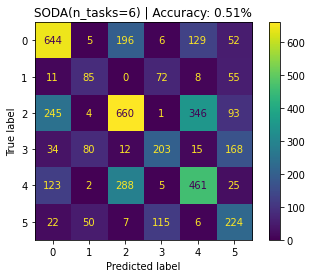

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
# plot_confusion_matrix(clf, x_val_total, y_val_total)  
predictions = clf.predict(x_test_total)
cm = confusion_matrix(y_test_total, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=clf.classes_)

disp.plot()
plt.title(f"SODA(n_tasks=6) | Accuracy: {round(clf.score(x_test_total, y_test_total), 2)}%")
plt.show();

## Utils for the incremental task classifier

In [132]:
import statistics as st

def get_task_classifier(memory):
    print("Getting Task Classifier")

    if len(memory) < 2:
        return None

    x_train_knn_total = np.vstack([_x_train.nearest_centroids for _x_train in memory])
    y_train_knn_total = np.hstack([np.repeat(mem.task, len(mem.nearest_centroids)) for mem in memory])

    print("x_train_knn_total shape: ", x_train_knn_total.shape)
    print("y_train_knn_total shape", y_train_knn_total.shape)

    task_classifier = NearestCentroid(metric='manhattan')
    task_classifier = task_classifier.fit(x_train_knn_total, y_train_knn_total)

    
    return task_classifier

    
def get_benchmark_method(task_classifier, benchmark_method_train_stream, benchmark_method_test_stream, benchmark_test_stream, 
                         new_training, new_testing, task=0):

    x_test_emb, y_test, t_test = get_embeddings(benchmark_method_test_stream[task].dataset)

    if task_classifier:
        print("Using the classifier:")
        task_labels = task_classifier.predict(x_test_emb)
        print("Count predictions: ", dict(zip(*np.unique(task_labels, return_counts=True))))
        print("Using the mode to get the most voted prediction:")
        mode = st.mode(task_labels)
        task_labels = np.repeat(mode, len(task_labels))
        print("Count predictions after: ", dict(zip(*np.unique(task_labels, return_counts=True))))
    else:
        print("Fist scenario: Task ID=", task)
        task_labels = np.repeat(task, len(benchmark_method_test_stream[task].dataset))
    print(f"Predictions: {np.random.choice(task_labels, 10)}")
    print(f"Predictions shape: {task_labels.shape}")

    new_training.append(benchmark_method_train_stream[task].dataset)
    new_testing.append(make_classification_dataset(benchmark_test_stream[task].dataset, task_labels=task_labels))

    benchmark_custom = dataset_benchmark(
        new_training, # will be ignored
        new_testing
    )

    return benchmark_custom

## Definition of Memory, Drift and Sequences

### Memory

In [85]:
from dataclasses import dataclass, InitVar
from typing import List
from alibi_detect.cd import MMDDrift

@dataclass
class Memory:
    task: int
    shape: List = None
    nearest_centroids: InitVar[List] = None
    def __post_init__(self, points):
        self.nearest_centroids = points
        self.shape = self.nearest_centroids.shape

### Drift

In [ ]:
def get_drift(x_ref, x_new):
    drift_detector = MMDDrift(x_ref, backend='pytorch', device=device)
    preds = drift_detector.predict(x_new)
    # drift = preds['data']['is_drift']
    drift = 0 if preds['data']['distance'] < 0 else 1
    print(f"Drift = {drift}")

    return drift

### Sequences

In [ ]:
def get_sequence(sequence, stream):
    return [stream[i] for i in sequence]
sequence = [0, 1, 1, 2]
stream_seq = get_sequence(sequence, benchmark_method.train_stream)
stream_seq

In [109]:
torch.all(stream_seq[1].dataset[0][0] == stream_seq[2].dataset[0][0])

tensor(True)

## Prepare the strategies to run

In [ ]:
def get_strategy(strategy_name, model, optimizer, criterion):
    n_epochs = 3
    strategies = {
        'EWC': EWC( #Regularization-based method
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            train_mb_size=200,
            train_epochs=n_epochs,
            eval_mb_size=200,
            device=device,
            evaluator=eval_plugin,
            ewc_lambda=0.2,
        ),
        'Replay': Replay( #Rehearsal-based method
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            train_mb_size=200,
            train_epochs=n_epochs,
            eval_mb_size=200,
            device=device,
            evaluator=eval_plugin,
            mem_size=2000,
        ),
        'LwF': LwF( #Architecture-based method
            model,
            optimizer,
            criterion,
            alpha=0.5,
            temperature=0.2,
            train_epochs=n_epochs,
            device=device,
            train_mb_size=200,
            eval_mb_size=200,
            evaluator=eval_plugin,
        ),
    }

    return strategies[strategy_name]

## Prepare and run the experiments

In [219]:
import torch
import random
import gc
from torch.nn import CrossEntropyLoss
import copy
import statistics as st
from torch.optim import Adam
from rich import print
from avalanche.models import as_multitask
from avalanche.benchmarks.classic import SplitMNIST, PermutedMNIST
from avalanche.models import MTSimpleMLP, MTSimpleCNN, SimpleCNN, SimpleMLP
# from avalanche.training.supervised import EWC, Naive, LFL
from avalanche.evaluation.metrics import (
    forgetting_metrics,
    accuracy_metrics,
)
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger
# from avalanche.training import Naive
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from avalanche.benchmarks.classic import SplitMNIST, PermutedMNIST, RotatedMNIST, SplitCIFAR10, SplitCIFAR100
from avalanche.benchmarks.generators import filelist_benchmark, dataset_benchmark
from avalanche.training.utils import adapt_classification_layer

from datetime import datetime
from avalanche.evaluation.metrics.images_samples import images_samples_metrics
from avalanche.evaluation.metrics.labels_repartition import (
    labels_repartition_metrics,
)
from avalanche.evaluation.metrics.mean_scores import mean_scores_metrics
from torch.nn import Linear
from avalanche.training.supervised import Replay, GEM, LwF, EWC


# choose some metrics and evaluation method
loggers = []

loggers.append(InteractiveLogger())

eval_plugin = EvaluationPlugin(
    accuracy_metrics(
        minibatch=False, epoch=False, experience=True
    ),

    # forgetting_metrics(experience=True),
    loggers=loggers,
)
    
num_experiments = 1
random_seeds = [42, 456, 123]

# results_list = []


for exp in range(num_experiments):
           
    memory = list()
    
    # train_stream = benchmark.train_stream
    # test_stream = benchmark.test_stream

    print(f"Length training: {len(benchmark.train_stream[0].dataset)}")
    print(f"Length testing: {len(benchmark.test_stream[0].dataset)}")

    print("-"*50)


    n_workers = 8

    seed = random_seeds[exp]
    random.seed(seed)
    torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    all_strategies = ['LwF']
    # all_strategies = ['EWC','Replay', 'LwF']
    for strategy_name in all_strategies:
        all_x_train_emb = list()
        all_y_train = list()
        all_t_train = list()

        all_x_test_emb = list()
        all_y_test = list()
        all_t_test = list()
    
        model = torchvision.models.resnet18(weights=True)
        model.fc = Linear(model.fc.in_features, 7, bias=True)
        mt_model = as_multitask(model, 'fc')

        optimizer = Adam(mt_model.parameters(), lr=0.01)
        criterion = CrossEntropyLoss()
        strategy = get_strategy(strategy_name, mt_model, optimizer, criterion)
        
        model2 = torchvision.models.resnet18(weights=True)
        model2.fc = Linear(model2.fc.in_features, 7, bias=True)
        mt_model2 = as_multitask(model2, 'fc')   
        optimizer2 = Adam(mt_model2.parameters(), lr=0.01)
        criterion2 = CrossEntropyLoss()
        strategy_no_task = get_strategy(strategy_name, mt_model2, optimizer2, criterion2)
        
        print(f"Running strategy: {strategy}, experiment: {exp}")
        results = {key: [] for key in ['ground_truth', 'TADIL', 'normal']}
        
        new_training = list()
        new_testing = list()

        memory = list()
        # sequence = [0, 1, 2]
        sequence = [0, 1, 2, 1, 3, 3, 4, 5]
        
        benchmark_train_stream = get_sequence(sequence, benchmark.train_stream)
        benchmark_method_train_stream = get_sequence(sequence, benchmark_method.train_stream)
        
        benchmark_test_stream = get_sequence(sequence, benchmark.test_stream)
        benchmark_method_test_stream = get_sequence(sequence, benchmark_method.test_stream)
        benchmark_no_task_test_stream = get_sequence(sequence, benchmark_no_task.test_stream)
        
        print(f"Sequence: {sequence}")
        for index, (task, experience) in enumerate(zip(sequence, benchmark_train_stream)):
            
            curr_experience = experience.current_experience
            print("Current experience: ", curr_experience)    
            print("Experience task ID ", experience.task_label)
            print('Experience shape:', len(experience.dataset))            

            drift_found = True
            x_new_emb, _, _ = get_embeddings(benchmark_method_train_stream[index].dataset)
            x_new_nearest_centroids = get_nearest_embedding_centroids(x_new_emb, n_neighbors=10)
            
            for x_ref in memory[::-1]:
                print(f"Calculating drift between Task(current={task}, memory={x_ref.task})")
                # print(f"Values(current={x_new_nearest_centroids[0][:5]}, memory={x_ref.nearest_centroids[0][:5]})") 
                if not get_drift(x_new_nearest_centroids, x_ref.nearest_centroids):
                    print("Using the task classifier to predict Task ID")
                    task_id_pred = task_classifier.predict(x_test_emb)
                    task_id_pred = st.mode(task_id_pred)
                    if task != task_id_pred:
                        print(f"Expected task is {task}, but predicted {task_id_pred}")
                        
                    print(f"Expected task {task} == predicted task {task_id_pred}")
                        
                    drift_found = False 
                    break #return

            if drift_found: # Or memory is empty
                print("Saving nearest centroids into Memory")
                memory.append(Memory(task=task, nearest_centroids=x_new_nearest_centroids))
                print("Memory:", memory)
                print(f"Memory tasks: {[m.task for m in memory]}")
                # Training
                print("Training multi-head model")
                strategy.train(experience, num_workers=n_workers)
                if index == 0:
                    strategy_no_task.model = strategy.model

                print('Training multi-head model completed')
                
                task_classifier = get_task_classifier(memory)
                
            # Run the method
            benchmark_custom = get_benchmark_method(task_classifier, benchmark_method_train_stream, 
                                                                     benchmark_method_test_stream, benchmark_test_stream, 
                                                                     new_training, new_testing, task=index)

            # Testing
            print("Evaluation benchmark: Ground Truth")
            results['ground_truth'].append(strategy.eval(benchmark_test_stream[:index+1], num_workers=n_workers))

            print("Evaluation benchmark: TADIL")
            results['TADIL'].append(strategy.eval(benchmark_custom.test_stream, num_workers=n_workers))

            print("Evaluation benchmark: Normal")
            results['normal'].append(strategy_no_task.eval(benchmark_no_task_test_stream[:index+1], num_workers=n_workers))

            print("-"*40)
            print()

        
        with open(f'Agnostic_online_{strategy_name}_{exp}.pickle', 'wb') as handle:
            pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
            print(f"Saved results for {strategy_name}, exp: {exp}:")

        print("-"*80)
        print()
    print("-"*80)

Length training: 4125

Length testing: 1032

--------------------------------------------------

/opt/intel/oneapi/intelpython/latest/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Running strategy: <avalanche.training.supervised.strategy_wrappers.LwF object at 0x7f1c6d04f550>, experiment: 0

Sequence: [0, 1, 2, 1, 3, 3, 4, 5]

Current experience:  0

Experience task ID  0

Experience shape: 4125

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Saving nearest centroids into Memory

Memory:
[Memory(task=0, shape=(11, 512))]

Memory tasks: [0]

Training multi-head model

-- >> Start of training phase << --
100%|██████████| 21/21 [00:18<00:00,  1.14it/s]
Epoch 0 ended.
100%|██████████| 21/21 [00:18<00:00,  1.12it/s]
Epoch 1 ended.
100%|██████████| 21/21 [00:42<00:00,  2.05s/it]
Epoch 2 ended.
-- >> End of training phase << --


Training multi-head model completed

Getting Task Classifier

Fist scenario: Task ID= 0

Predictions: [0 0 0 0 0 0 0 0 0 0]

Predictions shape: (1032,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5378
-- >> End of eval phase << --


Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5378
-- >> End of eval phase << --


Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5378
-- >> End of eval phase << --


----------------------------------------

Current experience:  1

Experience task ID  1

Experience shape: 923

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (1.19%):
(11, 512)

Calculating drift between Task(current=1, memory=0)

Drift = 1

Saving nearest centroids into Memory

Memory:
[Memory(task=0, shape=(11, 512)), Memory(task=1, shape=(11, 512))]

Memory tasks: [0, 1]

Training multi-head model

-- >> Start of training phase << --
100%|██████████| 5/5 [00:37<00:00,  7.53s/it]
Epoch 0 ended.
100%|██████████| 5/5 [00:26<00:00,  5.26s/it]
Epoch 1 ended.
100%|██████████| 5/5 [00:10<00:00,  2.03s/it]
Epoch 2 ended.
-- >> End of training phase << --


Training multi-head model completed

Getting Task Classifier

x_train_knn_total shape: 
(22, 512)

y_train_knn_total shape
(22,)

Using the classifier:

Count predictions: 
{0: 13, 1: 218}

Using the mode to get the most voted prediction:

Count predictions after: 
{1: 231}

Predictions: [1 1 1 1 1 1 1 1 1 1]

Predictions shape: (231,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5048
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.92s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.7143
-- >> End of eval phase << --


Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5048
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.92s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.7143
-- >> End of eval phase << --


Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5048
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.91s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.6017
-- >> End of eval phase << --


----------------------------------------

Current experience:  2

Experience task ID  2

Experience shape: 5393

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.2%):
(11, 512)

Calculating drift between Task(current=2, memory=1)

Drift = 1

Calculating drift between Task(current=2, memory=0)

Drift = 1

Saving nearest centroids into Memory

Memory:
[Memory(task=0, shape=(11, 512)), Memory(task=1, shape=(11, 512)), Memory(task=2, shape=(11, 512))]

Memory tasks: [0, 1, 2]

Training multi-head model

-- >> Start of training phase << --
100%|██████████| 27/27 [00:27<00:00,  1.02s/it]
Epoch 0 ended.
100%|██████████| 27/27 [00:28<00:00,  1.05s/it]
Epoch 1 ended.
100%|██████████| 27/27 [00:27<00:00,  1.01s/it]
Epoch 2 ended.
-- >> End of training phase << --


Training multi-head model completed

Getting Task Classifier

x_train_knn_total shape: 
(33, 512)

y_train_knn_total shape
(33,)

Using the classifier:

Count predictions: 
{0: 269, 1: 7, 2: 1073}

Using the mode to get the most voted prediction:

Count predictions after: 
{2: 1349}

Predictions: [2 2 2 2 2 2 2 2 2 2]

Predictions shape: (1349,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.4835
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.92s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.7965
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 7/7 [00:06<00:00,  1.01it/s]
> Eval on experience 2 (Task 2) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.5708
-- >> End of eval phase << --


Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.4835
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.98s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.7965
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 7/7 [00:06<00:00,  1.02it/s]
> Eval on experience 2 (Task 2) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.5708
-- >> End of eval phase << --


Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.4835
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.91s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.5671
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 7/7 [00:06<00:00,  1.01it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.4329
-- >> End of eval phase << --


----------------------------------------

Current experience:  1

Experience task ID  1

Experience shape: 923

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (1.19%):
(11, 512)

Calculating drift between Task(current=1, memory=2)

Drift = 1

Calculating drift between Task(current=1, memory=1)

Drift = 0

Using the task classifier to predict Task ID

Expected task 1 == predicted task 1

Using the classifier:

Count predictions: 
{0: 13, 1: 211, 2: 7}

Using the mode to get the most voted prediction:

Count predictions after: 
{1: 231}

Predictions: [1 1 1 1 1 1 1 1 1 1]

Predictions shape: (231,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.4835
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:06<00:00,  3.02s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.7965
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
> Eval on experience 2 (Task 2) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.5708
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:06<00:00,  3.02s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.7965
-- >> End of eval phase << --


Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.10s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.4835
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:06<00:00,  3.00s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.7965
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 7/7 [00:06<00:00,  1.03it/s]
> Eval on experience 2 (Task 2) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.5708
-- Starting eval on experience 3 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.97s/it]
> Eval on experience 3 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp003 = 0.7965
-- >> End of eval phase << --


Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.4835
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.97s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.5671
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.4329
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.97s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.5671
-- >> End of eval phase << --


----------------------------------------

Current experience:  3

Experience task ID  3

Experience shape: 2048

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.54%):
(11, 512)

Calculating drift between Task(current=3, memory=2)

Drift = 1

Calculating drift between Task(current=3, memory=1)

Drift = 1

Calculating drift between Task(current=3, memory=0)

Drift = 1

Saving nearest centroids into Memory

Memory:
[
    Memory(task=0, shape=(11, 512)),
    Memory(task=1, shape=(11, 512)),
    Memory(task=2, shape=(11, 512)),
    Memory(task=3, shape=(11, 512))
]

Memory tasks: [0, 1, 2, 3]

Training multi-head model

-- >> Start of training phase << --
100%|██████████| 11/11 [00:13<00:00,  1.22s/it]
Epoch 0 ended.
100%|██████████| 11/11 [00:13<00:00,  1.20s/it]
Epoch 1 ended.
100%|██████████| 11/11 [00:13<00:00,  1.26s/it]
Epoch 2 ended.
-- >> End of training phase << --


Training multi-head model completed

Getting Task Classifier

x_train_knn_total shape: 
(44, 512)

y_train_knn_total shape
(44,)

Using the classifier:

Count predictions: 
{0: 36, 1: 202, 2: 27, 3: 247}

Using the mode to get the most voted prediction:

Count predictions after: 
{3: 512}

Predictions: [3 3 3 3 3 3 3 3 3 3]

Predictions shape: (512,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5320
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.91s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.8312
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
> Eval on experience 2 (Task 2) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.5182
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:06<00:00,  3.01s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.8312
-- Starting eval on experience 3 (Task 3) from test stream --
100%|█

Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5320
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:06<00:00,  3.02s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.8312
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
> Eval on experience 2 (Task 2) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.5182
-- Starting eval on experience 3 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.98s/it]
> Eval on experience 3 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp003 = 0.8312
-- Starting eval on experience 4 (Task 3) from test stream --
100%|█

Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5320
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:05<00:00,  3.00s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.7965
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 7/7 [00:06<00:00,  1.01it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.5204
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:06<00:00,  3.01s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.7965
-- Starting eval on experience 3 (Task 0) from test stream --
100%|█

----------------------------------------

Current experience:  3

Experience task ID  3

Experience shape: 2048

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.54%):
(11, 512)

Calculating drift between Task(current=3, memory=3)

Drift = 0

Using the task classifier to predict Task ID

Expected task is 3, but predicted 1

Expected task 3 == predicted task 1

Using the classifier:

Count predictions: 
{0: 36, 1: 202, 2: 27, 3: 247}

Using the mode to get the most voted prediction:

Count predictions after: 
{3: 512}

Predictions: [3 3 3 3 3 3 3 3 3 3]

Predictions shape: (512,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5320
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.99s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.8312
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 7/7 [00:06<00:00,  1.01it/s]
> Eval on experience 2 (Task 2) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.5182
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:06<00:00,  3.02s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.8312
-- Starting eval on experience 3 (Task 3) from test stream --
100%|█

Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.10s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5320
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.99s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.8312
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 7/7 [00:06<00:00,  1.02it/s]
> Eval on experience 2 (Task 2) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.5182
-- Starting eval on experience 3 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.99s/it]
> Eval on experience 3 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp003 = 0.8312
-- Starting eval on experience 4 (Task 3) from test stream --
100%|█

Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5320
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:06<00:00,  3.04s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.7965
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 7/7 [00:06<00:00,  1.02it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.5204
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.99s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.7965
-- Starting eval on experience 3 (Task 0) from test stream --
100%|█

----------------------------------------

Current experience:  4

Experience task ID  4

Experience shape: 3613

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.3%):
(11, 512)

Calculating drift between Task(current=4, memory=3)

Drift = 1

Calculating drift between Task(current=4, memory=2)

Drift = 1

Calculating drift between Task(current=4, memory=1)

Drift = 1

Calculating drift between Task(current=4, memory=0)

Drift = 1

Saving nearest centroids into Memory

Memory:
[
    Memory(task=0, shape=(11, 512)),
    Memory(task=1, shape=(11, 512)),
    Memory(task=2, shape=(11, 512)),
    Memory(task=3, shape=(11, 512)),
    Memory(task=4, shape=(11, 512))
]

Memory tasks: [0, 1, 2, 3, 4]

Training multi-head model

-- >> Start of training phase << --
100%|██████████| 19/19 [00:18<00:00,  1.04it/s]
Epoch 0 ended.
100%|██████████| 19/19 [00:20<00:00,  1.09s/it]
Epoch 1 ended.
100%|██████████| 19/19 [00:21<00:00,  1.11s/it]
Epoch 2 ended.
-- >> End of training phase << --


Training multi-head model completed

Getting Task Classifier

x_train_knn_total shape: 
(55, 512)

y_train_knn_total shape
(55,)

Using the classifier:

Count predictions: 
{0: 127, 1: 5, 2: 305, 3: 6, 4: 461}

Using the mode to get the most voted prediction:

Count predictions after: 
{4: 904}

Predictions: [4 4 4 4 4 4 4 4 4 4]

Predictions shape: (904,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5717
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.94s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.8095
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 7/7 [00:06<00:00,  1.01it/s]
> Eval on experience 2 (Task 2) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.5322
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.92s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.8095
-- Starting eval on experience 3 (Task 3) from test stream --
100%|█

Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.11s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5717
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.97s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.8095
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 7/7 [00:06<00:00,  1.01it/s]
> Eval on experience 2 (Task 2) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.5322
-- Starting eval on experience 3 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.97s/it]
> Eval on experience 3 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp003 = 0.8095
-- Starting eval on experience 4 (Task 3) from test stream --
100%|█

Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5717
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:06<00:00,  3.01s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.8095
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.5167
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:05<00:00,  3.00s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.8095
-- Starting eval on experience 3 (Task 0) from test stream --
100%|█

----------------------------------------

Current experience:  5

Experience task ID  5

Experience shape: 1695

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.65%):
(11, 512)

Calculating drift between Task(current=5, memory=4)

Drift = 1

Calculating drift between Task(current=5, memory=3)

Drift = 1

Calculating drift between Task(current=5, memory=2)

Drift = 1

Calculating drift between Task(current=5, memory=1)

Drift = 1

Calculating drift between Task(current=5, memory=0)

Drift = 1

Saving nearest centroids into Memory

Memory:
[
    Memory(task=0, shape=(11, 512)),
    Memory(task=1, shape=(11, 512)),
    Memory(task=2, shape=(11, 512)),
    Memory(task=3, shape=(11, 512)),
    Memory(task=4, shape=(11, 512)),
    Memory(task=5, shape=(11, 512))
]

Memory tasks: [0, 1, 2, 3, 4, 5]

Training multi-head model

-- >> Start of training phase << --
100%|██████████| 9/9 [00:12<00:00,  1.39s/it]
Epoch 0 ended.
100%|██████████| 9/9 [00:12<00:00,  1.41s/it]
Epoch 1 ended.
100%|██████████| 9/9 [00:12<00:00,  1.35s/it]
Epoch 2 ended.
-- >> End of training phase << --


Training multi-head model completed

Getting Task Classifier

x_train_knn_total shape: 
(66, 512)

y_train_knn_total shape
(66,)

Using the classifier:

Count predictions: 
{0: 22, 1: 50, 2: 7, 3: 115, 4: 6, 5: 224}

Using the mode to get the most voted prediction:

Count predictions after: 
{5: 424}

Predictions: [5 5 5 5 5 5 5 5 5 5]

Predictions shape: (424,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5640
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.92s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.8312
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 7/7 [00:06<00:00,  1.01it/s]
> Eval on experience 2 (Task 2) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.5219
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.98s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.8312
-- Starting eval on experience 3 (Task 3) from test stream --
100%|█

Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5640
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.96s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.8312
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
> Eval on experience 2 (Task 2) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.5219
-- Starting eval on experience 3 (Task 1) from test stream --
100%|██████████| 2/2 [00:06<00:00,  3.01s/it]
> Eval on experience 3 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp003 = 0.8312
-- Starting eval on experience 4 (Task 3) from test stream --
100%|█

Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5640
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:06<00:00,  3.00s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.8182
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.5226
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.96s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.8182
-- Starting eval on experience 3 (Task 0) from test stream --
100%|█

----------------------------------------

Saved results for LwF, exp: 0:

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

## Plot the comparison using model's accuracies

### Get the results

In [220]:
strategy_name = "LwF"
n_exp = 0

with open(f'Agnostic_online_{strategy_name}_{n_exp}.pickle', 'rb') as handle:
    results = pickle.load(handle)

In [222]:
results.keys()

dict_keys(['ground_truth', 'TADIL', 'normal'])

In [141]:
# import matplotlib.pyplot as plt

# # Extract the eval_phase values
# def get_eval_phase_values(data, keyword):
#     eval_values = []
#     for exp in data:
#         eval_values.append({k: v for k, v in exp.items() if ('eval_phase/test_stream' in k) and (keyword in k)})
#     return eval_values

# results_clean = {k:get_eval_phase_values(results[k], "Top1_Acc_Exp") for k in results.keys()}

### Plot the numbers

<ipython-input-223-47e811329427>:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_tasks))


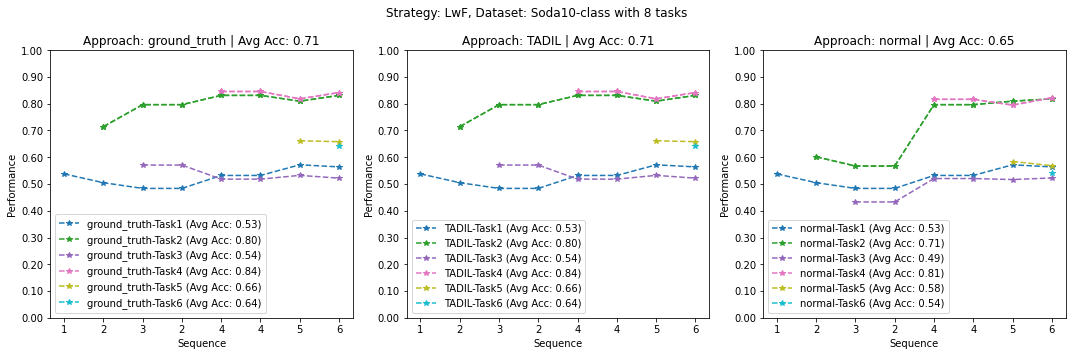

In [223]:
import matplotlib.pyplot as plt
import numpy as np

sequence = [0, 1, 2, 1, 3, 3, 4, 5]

method_scores = {
    'ground_truth': [],
    'TADIL': [],
    'normal': [],
}

unique_tasks = list(set(sequence))
for domain in sequence:
    scores_ground_truth = []
    scores_TADIL = []
    scores_normal = []
    iters_ = []
    for index, r in enumerate(results['ground_truth']):
        try:
            score_task = r[f"{metric_root_name}/Task00{domain}/Exp00{domain}"]
            score_TADIL = results['TADIL'][index][f"{metric_root_name}/Task00{domain}/Exp00{domain}"]
            score_normal = results['normal'][index][f"{metric_root_name}/Task00{0}/Exp00{domain}"]
            if score_task != 0:
                scores_ground_truth.append(score_task)
                scores_TADIL.append(score_TADIL)
                scores_normal.append(score_normal)
                iters_.append(index + 1)
        except:
            pass
    method_scores['ground_truth'].append((iters_, scores_ground_truth))
    method_scores['TADIL'].append((iters_, scores_TADIL))
    method_scores['normal'].append((iters_, scores_normal))

max_iter = max([max(scores, key=lambda s: s[0][-1])[0][-1] if scores else 0 for scores in method_scores.values()])

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle(f"Strategy: {strategy_name}, Dataset: Soda10-class with {len(results['ground_truth'])} tasks")

colors = plt.cm.get_cmap('tab10', len(unique_tasks))

plotted_tasks = set()

for i, (method_name, method_scores_list) in enumerate(method_scores.items()):
    
    avg_list = list()
    for j, (x, y) in enumerate(method_scores_list):
        average_accuracy = np.mean(y)
        avg_list.append(average_accuracy)
        label_task_num = sequence[j]
        if label_task_num not in plotted_tasks:
            axs[i].plot(x, y, '*--', color=colors(unique_tasks.index(label_task_num)), label=f'{method_name}-Task{label_task_num+1} (Avg Acc: {average_accuracy:.2f})')
            plotted_tasks.add(label_task_num)
        else:
            axs[i].plot(x, y, '*--', color=colors(unique_tasks.index(label_task_num)))
        axs[i].set_yticks(np.arange(0, 1.1, 0.1))
        axs[i].set_yticklabels(["{:.2f}".format(val) for val in np.arange(0, 1.1, 0.1)])
        axs[i].legend()
        
    plotted_tasks.clear()
    
    axs[i].set_title(f"Approach: {method_name} | Avg Acc: {round(np.mean(avg_list), 2)}")
    
    axs[i].set_xlabel("Sequence")
    axs[i].set_ylabel("Performance")
    axs[i].set_xticks(np.arange(1, len(sequence)+1))
    axs[i].set_xticklabels([str(task+1) for task in sequence])

plt.tight_layout()
plt.savefig(f'Agnostic_online_{strategy_name}.pdf', bbox_inches='tight', pad_inches=0)
plt.show()
